In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import nltk
import os


DELIM         = " +++$+++ "
CONVO_FILE    = "wikipedia.talkpages.conversations.txt"
USERS_FILE    = "wikipedia.talkpages.userinfo.txt"
ADMINS_FILE   = "wikipedia.talkpages.admins.txt"
POSTS_DF_FILE = "posts_df.pickle"
USERS_DF_FILE = "users_df.pickle"
POSTS_CSV     = "posts.csv"
USERS_CSV     = "users.csv"
NETWORK_FILE  = "users_network.pickle"
CORPUS_DIR    = ("../data/wiki/")
FWORDS_DIR    = '../data/function words/'

function_words = ['conjunctions', 'articles', 'prepositions', 'adverbs', 'quantifiers', 
           'impersonal_pronouns', 'personal_pronouns', 'auxiliary_verbs']

If the dataframes have been saved from a previous session, they can be loaded with this cell instead of running the cells that create them. Individual cells below can be run to re-compute columns in the dataframes.

In [2]:
if os.path.isfile(CORPUS_DIR + POSTS_DF_FILE):
    posts = pd.read_pickle(CORPUS_DIR + POSTS_DF_FILE)
if os.path.isfile(CORPUS_DIR + USERS_DF_FILE):
    users = pd.read_pickle(CORPUS_DIR + USERS_DF_FILE)

# Posts

## Create the `posts` dataframe

In [3]:
columns = ['utterance_id', 'user', 'talkpage_user', 'conversation_root', 'reply_to', 
           'timestamp', 'timestamp_unixtime', 'clean_text', 'raw_text']

posts = {column: [] for column in columns}
with open(CORPUS_DIR + CONVO_FILE) as f:
    for line in tqdm(f.readlines()):
        
        # parse lines from the conversations file
        if line.startswith("could not match") or line.strip() == "":
            continue
        line = line.rstrip('\n').split(DELIM)
        assert(len(line) == len(columns))
        line = {column: value for column, value in zip(columns, line)}
        
        # convert timestamps to datetime objects
        try:
            line['timestamp'] = datetime.strptime(line['timestamp'], "%Y-%m-%d %H:%M:%S")
        except ValueError:
            line['timestamp'] = None
            
        for column, value in line.items():
            posts[column].append(value)

            
posts = pd.DataFrame(data=posts, index=posts['utterance_id'], columns=columns, dtype=str)     

HBox(children=(IntProgress(value=0, max=516766), HTML(value='')))

## Tokenize posts

In [4]:
if not 'tokens' in posts.columns:
    tokens = [nltk.tokenize.word_tokenize(text) for text in tqdm(posts['clean_text'])]
    posts = posts.assign(tokens=tokens)

HBox(children=(IntProgress(value=0, max=391294), HTML(value='')))

## Detect formatting features

In [5]:
import re

bold = [False] * len(posts)
italics = [False] * len(posts)
links = [False] * len(posts)

for i, text in enumerate(tqdm(posts['clean_text'])):
    
    if re.search("'''''.+'''''", text):
        bold[i] = True
        italics[i] = True
    else:
        if re.search("'''.+'''", text):
            bold[i] = True
        if re.search("''.+''", text):
            italics[i] = True
            
    if re.search("\[\[.+\]\]", text):
        links[i] = True
        
posts = posts.assign(bold=bold, italics=italics, links=links)

HBox(children=(IntProgress(value=0, max=391294), HTML(value='')))

## Detect style markers

In [6]:
markers = {feature: [] for feature in function_words}
for feature in function_words:
    with open(FWORDS_DIR + feature + '.txt') as f:
        markers[feature] = [word.rstrip('\n') for word in f.readlines()]
        
feature_columns = {m: [False] * len(posts) for m in function_words}       
for i, tokens in enumerate(tqdm(posts['tokens'])):
    for m in function_words:
        if any(t.lower() in markers[m] for t in tokens):
            feature_columns[m][i] = True
        
posts = posts.assign(**feature_columns)

HBox(children=(IntProgress(value=0, max=391294), HTML(value='')))

## Record length (in tokens)

In [7]:
posts['length'] = posts['tokens'].apply(len)

## Compute perplexity

### RNN

In [8]:
from rnn_lm import Evaluator

MODEL_DIR = CORPUS_DIR + 'rnn_lm/nov-20-full/'
PPL_FILE  = MODEL_DIR + 'post_perplexities.csv'

if os.path.isfile(PPL_FILE): # load from previously computed file
    perplexity = pd.read_csv(PPL_FILE, dtype={'utterance_id': object, 'ppl_rnn': np.float64})
    perplexity.set_index('utterance_id', inplace=True)
    posts = posts.join(perplexity, how='left')

else: # compute with the RNN model
    evaluator = Evaluator(MODEL_DIR)
    perplexity = []
    for i, tokens in enumerate(tqdm(posts['tokens'])):
        if not tokens: # if the post is empty 
            perplexity.append(np.nan)
        else:
            perplexity.append(evaluator.perplexity(tokens))

    posts = posts.assign(ppl_rnn=perplexity)
    posts.to_csv(PPL_FILE, columns=['utterance_id', 'ppl_rnn'])  # save file

### KenLM

In [9]:
import kenlm

MODEL_DIR   = '../data/wiki/ken_lm/'
CORPUS_FILE = MODEL_DIR + 'corpus.txt'    

In [10]:
# create text corupus for training

if not os.path.isfile(CORPUS_FILE):
    with open(CORPUS_FILE, 'w') as f:
        f.write('\n'.join(posts['clean_text']))

In [11]:
%%bash
# build the KenLM model
if [ ! -e "../data/wiki/ken_lm/model.arpa" ]
then
    ./../kenlm/build/bin/lmplz -o 5 -S 80% --skip_symbols < ../data/wiki/ken_lm/corpus.txt > ../data/wiki/ken_lm/model.arpa
fi


In [12]:
import kenlm
MODEL_FILE = MODEL_DIR + 'model.arpa'
model = kenlm.Model(MODEL_FILE)
posts['ppl_kenlm'] = posts.clean_text.apply(model.perplexity)

# Users

In [13]:
columns = ['user', 'edit_count', 'gender', 'numerical_id']

users = {column: [] for column in columns}
with open(CORPUS_DIR + USERS_FILE) as f:
    for line in f.readlines():
        line = line.rstrip('\n').split(DELIM)
        assert(len(line) == len(columns))
        line = {column: value for column, value in zip(columns, line)}
        for column, value in line.items():
            users[column].append(value)
            
users = pd.DataFrame(data=users, index=users['user'], columns=columns)

## Admin info

In [14]:
columns = ['user', 'admin_ascension']

admins = {column: [] for column in columns}
with open(CORPUS_DIR + ADMINS_FILE) as f:
    for line in f.readlines():
        line = line.rstrip('\n').split(' ')
        line = ' '.join(line[:-1]), line[-1]
        assert(len(line) == len(columns))
        line = {column: value for column, value in zip(columns, line)}
            
        # convert timestamps to datetime objects
        try:
            line['admin_ascension'] = datetime.strptime(line['admin_ascension'], "%Y-%m-%d")
        except ValueError:
            line['admin_ascension'] = None
            
        for column, value in line.items():
            admins[column].append(value)
            
admins = pd.DataFrame(data=admins, index=admins['user'], columns=columns)
users = pd.merge(users, admins, on='user', how='left').set_index('user')
users['admin'] = users['admin_ascension'].notna()

## Average post features by user

In [15]:
# most of the post level features are binary --> frequency at the user level but these ones are scalar.
avg_cols = ['ppl_rnn', 'ppl_kenlm', 'length']  
avg_cols = {c + '_freq': c + '_avg' for c in avg_cols}  # rename dict for features that are averages
users = users.join(posts.groupby('user').mean().add_suffix('_freq').rename(columns=avg_cols))

# Construct Network

In [16]:
import networkx as nx

network = nx.Graph()

pairs = pd.merge(posts, posts, how='inner', left_on='reply_to', right_index=True, suffixes=['_b', '_a'])
for i, pair in tqdm(pairs.iterrows(), total=len(pairs)):
    user_a, user_b = pair['user_a'], pair['user_b']
    if user_a == user_b or ' ' in (user_a, user_b):
        continue  # ignore self-talk
    elif network.has_edge(user_a, user_b):
        network[user_a][user_b]['weight'] += 1
    else:
        network.add_edge(user_a, user_b, weight=1)
        
print("The unpruned network has {} notes (users).".format(len(network.nodes())))

# pruning the network to it's largest component:
minor_components = list(nx.connected_components(network))[1:]
disconnected_users = [user for com in minor_components for user in com]
network.remove_nodes_from(disconnected_users)
print("Removed {} users from {} disconnected components.".format(len(disconnected_users), len(minor_components)))

HBox(children=(IntProgress(value=0, max=240436), HTML(value='')))


The unpruned network has 27539 notes (users).
Removed 570 users from 275 disconnected components.


In [17]:
eigen_centrality = nx.eigenvector_centrality_numpy(network)
eigen_centrality = pd.DataFrame(list(eigen_centrality.items()), columns=['user', 'eigen_central'])
eigen_centrality.set_index('user', inplace=True)
users['eigen_central'] = eigen_centrality

## Binarize centrality

We binarize eigenvector centrality (highly central vs. not highly central) by taking those users whose cenrality is one standard deviation above the mean.

TODO: this is a problematic binarization technique becuase centrality is not normaly distributed...

In [35]:
users['eigen_central_bin'] = users['eigen_central'] > users['eigen_central'].mean() + users['eigen_central'].std()

## Find Louvian communities

In [19]:
import community # https://github.com/taynaud/python-louvain

partition = community.best_partition(network)
partition = pd.DataFrame(list(partition.items()), columns=['user', 'community'])
partition.set_index('user', inplace=True)
users = users.join(partition, how='left')

### Visualize the communities

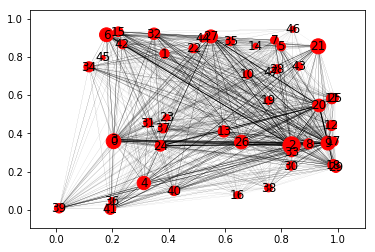

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import log

partition = users[pd.notna(users.community)].community.astype(int)
clusters = nx.Graph()
clusters.add_nodes_from(partition.unique(), weight=0)

for user in network.nodes():
    if user in partition:
        clusters.node[partition.loc[user]]['weight'] += 1

for (u, v), weight in nx.get_edge_attributes(network, 'weight').items():
    if u in partition and v in partition:
        u, v = partition[u], partition[v]
        if not clusters.has_edge(u, v):
            clusters.add_edge(u, v, weight=weight)
        else:
            clusters[u][v]['weight'] += weight
        
nodes = nx.get_node_attributes(clusters, 'weight').items()
edges = nx.get_edge_attributes(clusters, 'weight').items()

nodes, node_weights = zip(*nodes)
edges, edge_weights = zip(*edges)

node_weights = [w / max(node_weights) * 300 for w in node_weights]
edge_weights = [w / max(edge_weights) * 10 for w in edge_weights]

pos = nx.random_layout(clusters)
nx.draw_networkx_nodes(clusters, pos, nodes, node_size=node_weights)
nx.draw_networkx_labels(clusters, pos)
nx.draw_networkx_edges(clusters, pos, edgelist=edges, width=edge_weights)

plt.draw()

##  Coordination

### Coordination given

For a user $b$ and a group of users $A$, let $S^A_b$ be the set of pairs of utterances $(u_a, u_b)$ where $u_b$ is utterd by $b$ in reply to the parent utterance $u_a$, uttered by $a \in A$ 

$\mathcal{E}_m(u)$ means that utterance $u$ exhibits some linguistic marker, $m$.

Following *Echoes of Power* we define the coordination of user $b$ towards a group $A$ (the *coordination given* by $b$) as follows:
$$
C^g_m(A,b) = P\big[\mathcal{E}_m(u_b) \mid \mathcal{E}_m(u_a) \land (u_a, u_b) \in S^A_b\big] -
P\big[\mathcal{E}_m(u_b) \mid (u_a, u_b) \in S^A_b\big]
$$

The probabilities are estimated by counting occurances of $m$ in $S^A_b$:

$$
C^g_m(A,b) \approx \sum_{(u_a,u_b)\in S^A_b}\Big({
\frac{[\mathcal{E}_m(u_a) \land \mathcal{E}_m(u_b)]}{[\mathcal{E}_m(u_a)]} - 
\frac{[\mathcal{E}_m(u_b)]}{1}}  \Big)
$$

$C^m(A,b)$ is defined for $m$, $b$ and $A$ where $b$ where $\{(u_a, u_b) \in S^A_b \mid \mathcal{E}_m(u_a)\} \neq \varnothing $.

In [21]:
def get_coord(pairs, prefix):

    pairs = pairs.assign(count=[1] * len(pairs))  # for summing later

    # for each marker, add column indicating if both parent & reply exhibits m
    both_exhibit_m = {}
    for m in function_words:
        both_exhibit_m[m + '_both'] = pairs[m + '_b'] & pairs[m + '_A']
    pairs = pairs.assign(**both_exhibit_m)

    total = pairs.groupby('user_b').sum()

    coord = {}
    for m in function_words:
        coord[prefix + m] = total[m + '_both'] / total[m + '_b'] - total[m + '_A'] / total['count']
    coord = pd.DataFrame(coord) 
    coord[prefix + 'aggrigate'] = coord.mean(axis=1, skipna=True)
    
    return coord

In [22]:
# join posts with their parent posts (where b is responding to a in A)
pairs = pd.merge(posts, posts, how='inner', left_index=True, right_on='reply_to', suffixes=['_A', '_b'])
coord_given = get_coord(pairs, 'coord_given_')

users = users.join(coord_given, how='left')

### Coordination Received

Likewise, we estimate the coordination of a group $A$ towards a user $b$ (the *coordination received* by $b$) as:

$$
C^r_m(A,b) \approx \sum_{(u_b,u_a)\in S^b_A}\Big({
\frac{[\mathcal{E}_m(u_b) \land \mathcal{E}_m(u_a)]}{[\mathcal{E}_m(u_b)]} - 
\frac{[\mathcal{E}_m(u_a)]}{1}}  \Big)
$$

where $S^b_A$ is the set of pairs of utterances where a member of group $A$ is replying to an utteance of user $b$ (note that this is an entirely distinct set from $S^A_b$).

As before, $C^r_m(A,b)$ is defined if $\{(u_b, u_a) \in S^b_A \mid \mathcal{E}_m(u_b)\} \neq \varnothing $

In both cases, to aggregate over markers, we take the average of the marker-specific coordination measures for which $C^*_m(A,b)$ is defined.

First, we calculate each user's coordination (given and received) with respect to the general population:

In [23]:
# join posts with their parent posts (where a in A is responding to b)
pairs = pd.merge(posts, posts, how='inner', left_index=True, right_on='reply_to', suffixes=['_b', '_A'])
coord_received = get_coord(pairs, 'coord_received_')

users = users.join(coord_received, how='left')

### Coordination by community

Now we want to see how users coordinate (and are coordinated with) by users inside and outside of their own Louvian communities.

In [24]:
pairs = pd.merge(posts, posts, how='inner', left_index=True, right_on='reply_to', suffixes=['_A', '_b'])
# merege with `users` to get the Louvian community
pairs = pd.merge(pairs, users[['community']], left_on='user_A', right_index=True).rename(columns={'community': 'community_A'})
pairs = pd.merge(pairs, users[['community']], left_on='user_b', right_index=True).rename(columns={'community': 'community_b'})

# split the reply pairs by whether the users belong to the same community or not
coord_given_ingroup = get_coord(pairs[pairs.community_A == pairs.community_b], 'ingroup_coord_given_')
coord_given_outgroup = get_coord(pairs[pairs.community_A != pairs.community_b], 'outgroup_coord_given_')

# only record the aggrigate for now.. may be too much otherwise
users = users.join(coord_given_ingroup[['ingroup_coord_given_aggrigate']], how='left')
users = users.join(coord_given_outgroup[['outgroup_coord_given_aggrigate']], how='right')

In [25]:
# same thing for coordination received 

pairs = pd.merge(posts, posts, how='inner', left_index=True, right_on='reply_to', suffixes=['_b', '_A'])
# merege with `users` to get the Louvian community
pairs = pd.merge(pairs, users[['community']], left_on='user_A', right_index=True).rename(columns={'community': 'community_A'})
pairs = pd.merge(pairs, users[['community']], left_on='user_b', right_index=True).rename(columns={'community': 'community_b'})

# split the reply pairs by whether the users belong to the same community or not
coord_given_ingroup = get_coord(pairs[pairs.community_A == pairs.community_b], 'ingroup_coord_received_')
coord_given_outgroup = get_coord(pairs[pairs.community_A != pairs.community_b], 'outgroup_coord_received_')

# only record the aggrigate for now.. may be too much otherwise
users = users.join(coord_given_ingroup[['ingroup_coord_received_aggrigate']], how='left')
users = users.join(coord_given_outgroup[['outgroup_coord_received_aggrigate']], how='right')

# Save data

In [36]:
posts.to_csv(CORPUS_DIR + POSTS_CSV)
users.to_csv(CORPUS_DIR + USERS_CSV)

In [37]:
posts.to_pickle(CORPUS_DIR + POSTS_DF_FILE)
users.to_pickle(CORPUS_DIR + USERS_DF_FILE)

user_b
!!                      NaN
$1LENCE D00600D         NaN
(aeropagitica)          NaN
*Paul*                  NaN
*Ulla*                  NaN
-5-                     NaN
-Lemmy-                 NaN
-Marcus-                NaN
.snoopy.                NaN
07fan                   NaN
08OceanBeach SD         NaN
100110100               NaN
101090ABC               NaN
117Avenue               NaN
12345abcxyz20082009     NaN
1234r00t                NaN
157.228.x.x             NaN
172                     NaN
194x144x90x118          NaN
1B6                     NaN
1exec1                  NaN
1of3                    NaN
20-dude                 NaN
21stCenturyGreenstuff   NaN
23skidoo                NaN
28bytes                 NaN
293.xx.xxx.xx           NaN
2over0                  NaN
334a                    NaN
33rogers                NaN
                         ..
Zippy                   NaN
Zir                     NaN
ZjarriRrethues          NaN
Zlerman                 NaN
Znode        